# Exploration and Preprocessing of VGP database

This notebook preprocessing site level data from the VGP database compilation, conducts associated statistical tests and makes visualizations of data at the study level.

## Import scientific Python libraries

Import scipy python libraries as well as functions written for the project within vgptools.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, 
                               print_pole_statistics, test_fishqq, 
                               statistical_tests, summary_figure,
                               invert_polarity, Plot_VgpsAndSites)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Gather study files

We retrieve all the spreadsheet files corresponding to different studies for which site level data are compiled. 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] 
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

,name_xlsx
0,Tequila_volcanic_field
1,Coso_Range_volcanics
2,Eastern_Alkaline_Province
3,SW_USA_composite
4,N_Montana_intrusions
5,Long_Valley_Caldera_volcanics
6,Robinson_Antincline_intrusions
7,Central_Mexico_Plio-Pleistocene
8,Rattlesnake_Hills_volcanics
9,Ramsay_Island_lavas


## Single study inspection

In order to understand what is going on in one single site, we can conduct statistical tests and visualize the data. 

In [48]:
file_idx = 0

#### Separate the *.xlsx file into two different DFs, `df_vgps` and `df_poles`. 

*Note: the the number of lines to be skipped is hardcoded.*

In [49]:
def split_datasheet(df_files, file_idx):
    """
    Reads in datasheets and splits them into pole and vgp collections to be filtered, collated and compiled.
    Input: standard vgp datasheet (as described in datasheet template)
    Output: separate dataframes comprised of the study-level poles and site-level vgps extracted from the datasheet
    """
    df = pd.read_excel(df_files['path'][file_idx]) #, skip_blank_lines=True
    df_poles = pd.read_excel(df_files['path'][file_idx], 
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(df_files['path'][file_idx], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "VGP_lat":float, "VGP_lon":float
                             })
    df_poles = df_poles.astype({'N': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "Plat":float, "Plon":float})
    return (df_poles, df_vgps)

df_poles, df_vgps = split_datasheet(df_files, file_idx)

## We then proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 1. In a previous step, we have calculated the site coordinates of all studies in which these coordinates were not reported, but the Dec/Inc and Plat/Plon were. 
 2. We recalculate the VGP longitudes and latitudes based on the site mean declination/inclination and site location longitude/latitude.

In [50]:
#First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
def recalc_vgps(df_vgps):
    df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    return df_vgps

df_vgps = recalc_vgps(df_vgps)

## Check polarity of VGPs against directions
 3. Some sites report the backward VGP (so that the VGPs are in the same hemisphere/closer to the principal component). We proceed to check polarity of VGPs against directions. To do that, we recalculate the vgps from the original Dec/Inc.
 
4. Check distance (`df_vgps['GCD_vgps']`) between the reported VGPs and the recalculated from the directions.

In this step we fill the column `df_vgps['coherent_vgps']` with the following tags: 
- 'spurious' if inconsistent combination of site coordinates + dec/inc + vgp data (+- 4 degrees away from the reported or its backward)
- 'coherent' if correct
- 'inverted' if inverted

In [51]:
def check_coherence_vgps(df_vgps):

    df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

    # False if Spurious, True if correct, nan if inverted
    df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: 'spurious' if (row.GCD_vgps > np.radians(4) and row.GCD_vgps < np.radians(176)) else ('coherent' if row.GCD_vgps < np.radians(4) else 'inverted' if row.GCD_vgps > np.radians(176) else np.nan ), axis =1) #True if it is ok, nan
    
    return df_vgps
df_vgps = check_coherence_vgps(df_vgps)

### Catch some exceptions:
 - Missing slat/slon and/or dec/in where no vgp is reported
 - Missing dec/inc and/or vgp where no site coordinates are reported; cannot calculate site locations.
 - Inconsistent combination of site coordinates + dec/inc + vgp
 - Recalculated VGP was inverted. 

In [52]:
def verbose(df_vgps):
    
    if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna())].empty:
        print (f" => Missing slat/slon from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna())].empty:
        print (f" => Missing dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
        print (f" => Missing reported VGPs from sites ('name'): {df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].empty:    
        print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'spurious'].empty:
        print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == 'spurious'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'inverted'].empty:
        print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'inverted'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'coherent'].empty:
        print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'coherent'].name.tolist()}")
        print (f"")
        
verbose(df_vgps)

 => Coherent dec/inc in sites ('name'): ['TL1', 'TL5', 'TM3', 'TM2', 'TM1', 'TM6', 'TM11', 'TM10', 'TM9', 'TL2', 'TL9', 'TM5', 'TM8', 'TL3', 'TL12', 'TL4', 'TL10', 'TL7', 'TL11', 'TM4', 'TM7']



### Summarize site level data

For each reported pole from the selected manuscript, we iterate through the constituent site-level data and: 
1) cast all vgps into a common polarity and re-compute the Fisher mean paleomagnetic pole
2) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

==>Analyzing pole 1 (Tequila_volcanic_field).



,N,Plat,Plon,A95
Reported mean pole,17,85.8,84.3,6.9
Mean pole (calculated from VGPs),17,85.8,84.4,6.9
Mean pole (calculated from transformed directions),17,85.4,83.9,6.9


Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


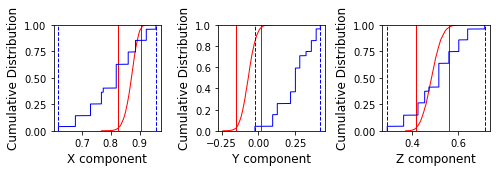

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           4.3
Critical value of V:  11.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 18.8
Critical angle for M&M1990:   30.5
The McFadden and McElhinny (1990) classification for
this test is: 'INDETERMINATE;

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Ambiguous: weak support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


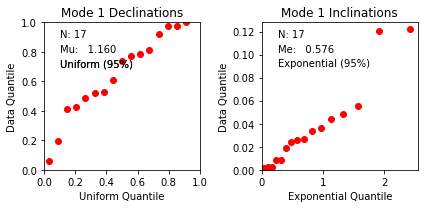

Consistent with Fisher distribution


,result
Bootstrap reversal test,Pass
Parametric reversal test,Pass (angle 18.8º below 30.5º critical angle); indeterminate classification
Bayesian reversal test,Ambiguous: weak support
Fisher Q-Q test,Consistent with Fisher distribution


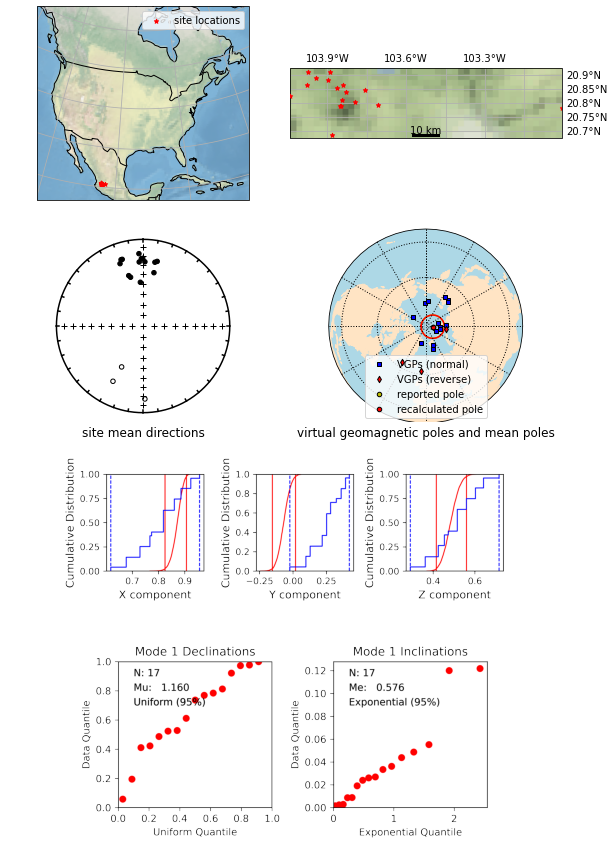

In [53]:
studies, pps, misfit, misfit_type = [], [], [], []

def process_study(df_vgps,file_idx):
    for pole, df_pole in df_vgps.groupby('in_study_pole'):

        # value represent the index and i represent the DF grouped by the variable of interest  
        if pole != 0: #does not consider vgps discarded by authors

            print(f"==>Analyzing pole {pole} ({df_files.name_xlsx[file_idx]}).")
            print('')

            directions_block = ipmag.make_di_block(df_pole['dec'].tolist(), 
                                                   df_pole['inc'].tolist(),
                                                   unit_vector=False)
            di_mode1, di_mode2 = pmag.separate_directions(di_block=directions_block)

            vgp_recalc_block = ipmag.make_di_block(df_pole['VGP_lon_recalc'].tolist(), 
                                                   df_pole['VGP_lat_recalc'].tolist(),
                                                   unit_vector=False)
            #split recalculated vgp population into polarities             
            vgp_mode1, vgp_mode2 = pmag.separate_directions(di_block=vgp_recalc_block)
            merged_vgps = invert_polarity(vgp_mode1, vgp_mode2)
            vgp_mean_recomputed = ipmag.fisher_mean(di_block = merged_vgps)

            # calculate the Fisher mean of reported VGPs
            df_pole['VGP_lat'] = np.where(df_pole['VGP_lat'].isna(), df_pole['VGP_lat_recalc'], df_pole['VGP_lat'])
            df_pole['VGP_lon'] = np.where(df_pole['VGP_lon'].isna(), df_pole['VGP_lon_recalc'], df_pole['VGP_lon'])
            df_pole['vgp_lat_NH'] = np.where(df_pole['VGP_lat'] < 0, -df_pole['VGP_lat'], df_pole['VGP_lat'])
            df_pole['vgp_lon_NH'] = np.where(df_pole['VGP_lat'] < 0,(df_pole['VGP_lon'] - 180.) % 360., df_pole['VGP_lon'])             
            vgp_mean = ipmag.fisher_mean(dec = df_pole['vgp_lon_NH'].tolist(), inc = df_pole['vgp_lat_NH'].tolist())

            #reported pole
            reported_pole = df_poles[df_poles['pole'] == pole]

            study_number = file_idx
            study_folder = './study_summaries' + '/' + str(study_number)
            if not os.path.exists(study_folder):
                os.mkdir(study_folder)

            pole_number = pole
            pole_folder = study_folder + '/' + str(pole_number)
            if not os.path.exists(pole_folder):
                os.mkdir(pole_folder)

            pole_summary = print_pole_statistics(reported_pole, 
                                                 vgp_mean, 
                                                 vgp_mean_recomputed)

            with open(pole_folder + '/pole_summary.tex','w') as tf:
                tf.write(pole_summary.to_latex())

            stat_test_results = statistical_tests(di_mode1, di_mode2, merged_vgps, 
                                                  study_number=file_idx, 
                                                  pole_number=pole, 
                                                  save_folder=pole_folder)

            with open(pole_folder + '/stat_test.tex','w') as tf:
                tf.write(stat_test_results.to_latex())

            summary_figure(df_pole, vgp_mode1, vgp_mode2, 
                           reported_pole, vgp_mean, pole_folder)

            study_name = str(df_files.name_xlsx[file_idx])
            study_name = study_name.replace('_', ' ')
            pole_local_folder = './' + str(study_number) + '/' + str(pole_number)
            tex_file = open('./study_summaries/SI_study_summary.tex', 'a')
            tex_file.write('\n')

            if pole_number == 1:
                tex_file.write('\section{' + study_name + '}')
                tex_file.write('\n')
                tex_file.write('\subsection{Pole ' + str(pole) + '}')
            if pole_number > 1:
                tex_file.write('\subsection{Pole ' + str(pole) + '}')
            tex_file.write('\n')
            tex_file.write('\input{' + pole_local_folder + '/pole_summary.tex' + '}')
            tex_file.write('\n')
            tex_file.write('\input{' + pole_local_folder + '/stat_test.tex' + '}')
            tex_file.write('\n')
            tex_file.write('\\begin{figure}[H]')
            tex_file.write('\n')
            tex_file.write('\centering')
            tex_file.write('\n')
            tex_file.write('\includegraphics[width=5 in]{' + pole_local_folder + '/pole_summary.png}')
            tex_file.write('\n')
            tex_file.write('\caption{Summary of data from locality ' + str(file_idx) + ' (' + study_name + ') pole ' + str(pole) + ' (' + reported_pole['pmag_ref'].tolist()[0] + ').}')
            tex_file.write('\n')
            tex_file.write('\end{figure}')
            tex_file.write('\n')
            tex_file.close()

            studies.append(df_files.name_xlsx[file_idx])
            pps.append(pole)
            misfit.append(pmag.angle([vgp_mean['dec'], vgp_mean['inc']], 
                                   [reported_pole.iloc[0]['Plon'], reported_pole.iloc[0]['Plat']])[0])
            misfit_type.append('reported')

            studies.append(df_files.name_xlsx[file_idx])
            pps.append(pole)                
            misfit.append(pmag.angle([vgp_mean_recomputed['dec'], vgp_mean_recomputed['inc']], 
                                   [reported_pole.iloc[0]['Plon'], reported_pole.iloc[0]['Plat']])[0])
            misfit_type.append('recalculated')
                
            print('')
            plt.pause(10)
            
process_study(df_vgps,file_idx)

In [54]:
misfit

[0.03493522315521061, 0.37949340892949235]

# Iterate through all the files to generate summary plots and catch exceptions:


========================= NEW POLE : Tequila_volcanic_field (0) =======================
 => Coherent dec/inc in sites ('name'): ['TL1', 'TL5', 'TM3', 'TM2', 'TM1', 'TM6', 'TM11', 'TM10', 'TM9', 'TL2', 'TL9', 'TM5', 'TM8', 'TL3', 'TL12', 'TL4', 'TL10', 'TL7', 'TL11', 'TM4', 'TM7']

==>Analyzing pole 1 (Tequila_volcanic_field).



,N,Plat,Plon,A95
Reported mean pole,17,85.8,84.3,6.9
Mean pole (calculated from VGPs),17,85.8,84.4,6.9
Mean pole (calculated from transformed directions),17,85.4,83.9,6.9


Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


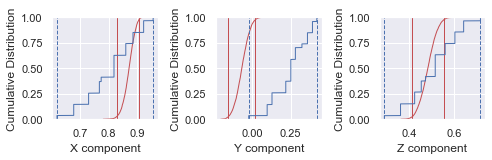

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           4.3
Critical value of V:  11.2
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 18.8
Critical angle for M&M1990:   30.6
The McFadden and McElhinny (1990) classification for
this test is: 'INDETERMINATE;

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Ambiguous: weak support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


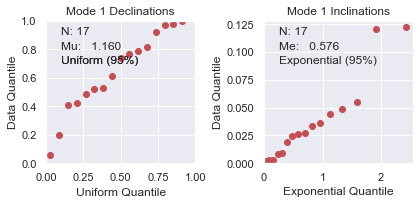

Consistent with Fisher distribution


,result
Bootstrap reversal test,Pass
Parametric reversal test,Pass (angle 18.8º below 30.6º critical angle); indeterminate classification
Bayesian reversal test,Ambiguous: weak support
Fisher Q-Q test,Consistent with Fisher distribution


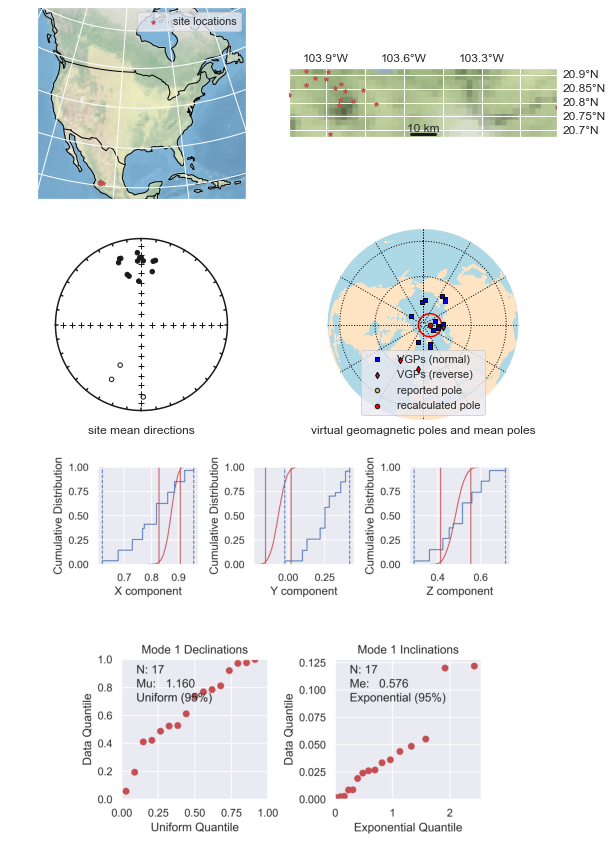


========================= NEW POLE : Coso_Range_volcanics (1) =======================
 => Coherent dec/inc in sites ('name'): [58.0, 35.0, 32.0, 33.0]

==>Analyzing pole 1 (Coso_Range_volcanics).



,N,Plat,Plon,A95
Reported mean pole,2,NaN,NaN,NaN
Mean pole (calculated from VGPs),2,73.8,69.3,66.8
Mean pole (calculated from transformed directions),2,73.8,69.3,66.8



Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------
Not enough sites to conduct Q-Q test


,result
Bootstrap reversal test,Too few sites for test
Parametric reversal test,Too few sites for test
Bayesian reversal test,Different means: strong support
Fisher Q-Q test,Too few sites


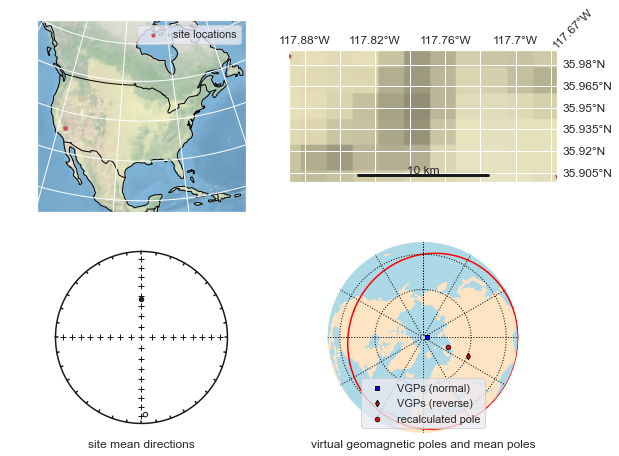

In [60]:
studies, pps, misfit, misfit_type = [], [], [], []

for file_idx in range(0,2):
    print(f'')
    print(f'========================= NEW POLE : {df_files.name_xlsx[file_idx]} ({file_idx}) =======================')
    
    df_poles, df_vgps = split_datasheet(df_files, file_idx)
    df_vgps = recalc_vgps(df_vgps)
    df_vgps = check_coherence_vgps(df_vgps)
    verbose(df_vgps)
    process_study(df_vgps,file_idx)   

In [61]:
misfit

[0.03493522315521061, 0.37949340892949235, nan, nan]

In [64]:
dictionary= {'Study': studies, 'in_study_pole': pps, 'Misfit': misfit, 'From' : misfit_type}
df_misfits = pd.DataFrame(dictionary)

df_misfits = df_misfits[~df_misfits['Misfit'].isna()]

df_misfits['Misfit'] = np.where(df_misfits['Misfit'] > 90, 180 - df_misfits['Misfit'], df_misfits['Misfit'])
df_misfits

,Study,in_study_pole,Misfit,From
0,Tequila_volcanic_field,1,0.034935,reported
1,Tequila_volcanic_field,1,0.379493,recalculated


[Text(0.5, 1.0, 'Distance from the reported Paleopole and the reported VGPs')]

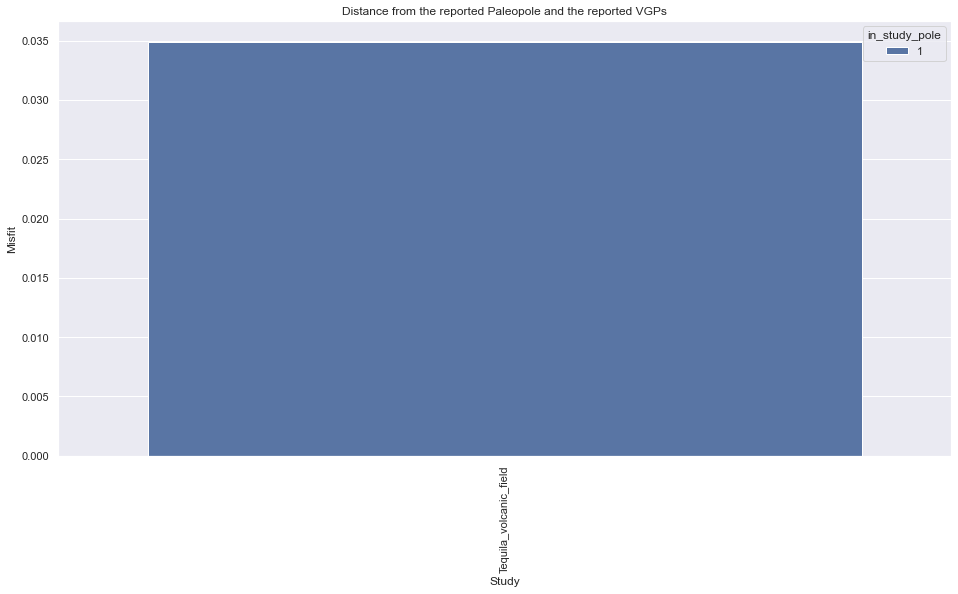

In [58]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Study", y= "Misfit", hue="in_study_pole", data=df_misfits[df_misfits['From'] == 'reported'])
ax.tick_params(axis='x', rotation=90)
ax.set(title = "Angular distance between reported paleopole and pole calculated from reported VGPs")
#ax.xaxis.get_label().set_fontsize(20)

[Text(0.5, 1.0, 'Distance from the reported Paleopole and the recalculated VGPs')]

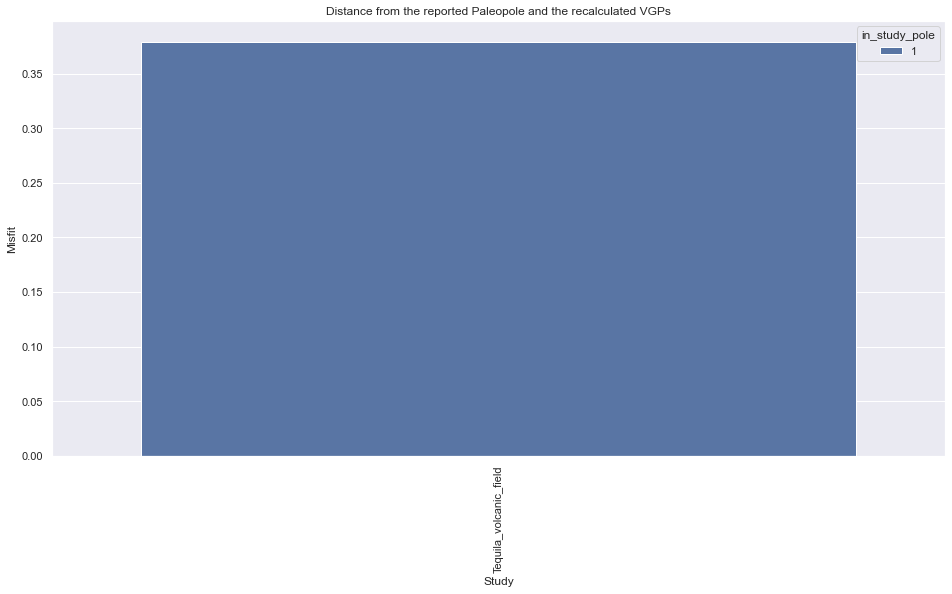

In [59]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Study", y= "Misfit", hue="in_study_pole", data=df_misfits[df_misfits['From'] == 'recalculated'])
ax.tick_params(axis='x', rotation=90)
ax.set(title = "Angular distance between reported paleopole and pole calculated from recalculated VGPs")
#ax.xaxis.get_label().set_fontsize(20)